# Data Sources

In [38]:
import requests 
import pandas as pd
import json
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from itertools import product
import io
import oracledb
import seaborn as sns
import matplotlib.pyplot as plt 
import os 

os.environ["TNS_ADMIN"] = r"C:\Users\addel\Downloads\Wallet_DS320Flights\cwallet.sso"


In [6]:
with open('keys.json', 'r') as KeysFile:
    data = json.load(KeysFile)

aviationStackAPIKey = data["Aviation Stack API KEY"]
username = "admin"
password = data["Oracle Password"]
dsn = data["DB Name"]

## Country Data

In [3]:
def getCountryCodes(country: str):
    urlCountry = f"https://api.aviationstack.com/v1/countries?access_key={aviationStackAPIKey}"
    queryStringCountry = {"search": country}
    responseCountry = requests.get(urlCountry, params=queryStringCountry)
    responseCountry = responseCountry.json()
    responseCountry = responseCountry.get('data')
    codes = [c.get('country_iso2') for c in responseCountry]
    return codes

In [4]:
def getAirportsByCountry(code: str):
    urlAirport = f"https://api.aviationstack.com/v1/airports?access_key={aviationStackAPIKey}"

    offset = 0
    all_data = []
    
    while True:
        queryStringAirport = {"offset": offset, "country_iso": code, "type": "international"}
        responseAirport = requests.get(urlAirport, params=queryStringAirport)
        responseAirport = responseAirport.json()
        
        currentData = responseAirport.get('data', [])
        currentData = [airP for airP in currentData if airP.get('country_iso2') == code]
        all_data.extend(currentData)
        
        if offset + 100 >= responseAirport.get('pagination').get('total'):
            break
        
        offset += 100
    
    airports_df = pd.DataFrame(columns=['IATA', 'CountryCode', 'AirportName', 'Country'])
    
    for case in all_data:
        new_case = {'IATA': case.get('iata_code', ''),
                    'CountryCode': case.get('country_iso2', ''),
                    'AirportName': case.get('airport_name', ''),
                    'Country': case.get('country_name', '')}
        airports_df.loc[len(airports_df)] = new_case
        
    return airports_df

## Historical Flight Data

In [5]:
def getHistoricalFlights(departureIATA: str=None, arrivalIATA: str=None, date: str=None):
    url = f"https://api.aviationstack.com/v1/flights?access_key={aviationStackAPIKey}"
    queryString = {"limit": 100, "dep_iata": departureIATA, "arr_iata": arrivalIATA, "flight_date": date}
    queryString = {key: value for key, value in queryString.items() if value is not None}
    print(queryString)
    response = requests.get(url, params=queryString)
    if response.status_code != 200:
        print(response)
        return None

    response = response.json()
    response = response['data']
    flights_df = pd.DataFrame(columns=['Date', 'DepartureIATA', 'DepartureTime', 'ArrivalIATA', 'ArrivalTime', 'Aircraft', 'AirlineName', 'AirlineIATA', 'FlightNumberIATA'])
    for flight in response:
        if isinstance(flight, dict) and flight.get('flight', {}).get('codeshared') is None:
            new_case = {
                'Date': date,
                'DepartureIATA': flight.get('departure', {}).get('iata', None),
                'DepartureTime': flight.get('departure', {}).get('scheduled', None),
                'ArrivalIATA': flight.get('arrival', {}).get('iata', None),
                'ArrivalTime': flight.get('arrival', {}).get('scheduled', None),
                'Aircraft': flight.get('aircraft', {}).get('iata', None) if flight.get('aircraft') is not None else None,
                'AirlineName': flight.get('airline', {}).get('name', None),
                'AirlineIATA': flight.get('airline', {}).get('iata', None),
                'FlightNumberIATA': flight.get('flight', {}).get('iata', None)
            }
            flights_df.loc[len(flights_df)] = new_case

    return flights_df

### Get Country Codes for US Brazil Portugal Canada Italy France

In [6]:
US_codes = getCountryCodes('United States')
Brazil_codes = getCountryCodes('Brazil')
Portugal_codes = getCountryCodes('Portugal')
Mexico_codes = getCountryCodes('Mexico')
Italy_codes = getCountryCodes('Italy')
France_codes = getCountryCodes('France')

In [7]:
print(f"Country codes:\nUS: {US_codes}\nBrazil: {Brazil_codes}\nPortugal: {Portugal_codes}\nMexico: {Mexico_codes}\nItaly: {Italy_codes}\nFrance: {France_codes}")

Country codes:
US: ['UM', 'US']
Brazil: ['BR']
Portugal: ['PT']
Mexico: ['MX']
Italy: ['IT']
France: ['FR', 'MQ']


In [8]:
US_airports = ['JFK', 'ATL', 'DTW', 'LAX']
Italy_airports = ['FCO']
France_airports = ['CDG']
Brazil_airports = ['GRU']
Portugal_airports = ['LIS']
Mexico_airports = ['CUN']

In [9]:
US_Italy = list(product(US_airports, Italy_airports))
US_France = list(product(US_airports, France_airports))
US_Brazil = list(product(US_airports, Brazil_airports))
US_Portugal = list(product(US_airports, Portugal_airports))
US_Mexico = list(product(US_airports, Mexico_airports))
airport_combinations = US_Italy + US_France + US_Brazil + US_Portugal + US_Mexico

In [10]:
dates = [datetime(2024, 1, 1) + timedelta(days=i) for i in range(366)]
dates = [i.strftime("%Y-%m-%d") for i in dates]

In [ ]:
df_all_flights = pd.DataFrame(columns=['Date', 'DepartureIATA', 'DepartureTime', 'ArrivalIATA', 'ArrivalTime', 'Aircraft', 'AirlineName', 'AirlineIATA', 'FlightNumberIATA'])
for city_pair in airport_combinations:
    for current_date in dates:
        temp_df = getHistoricalFlights(departureIATA=city_pair[0], arrivalIATA=city_pair[1], date=current_date)
        df_all_flights = pd.concat([temp_df, df_all_flights], ignore_index=True)

In [14]:
df_all_flights.head()

,Date,DepartureIATA,DepartureTime,ArrivalIATA,ArrivalTime,Aircraft,AirlineName,AirlineIATA,FlightNumberIATA
0,2024-12-11,LAX,2024-12-11 10:36:00,CUN,2024-12-11 18:19:00,B39M,Alaska Airlines,AS,AS1332
1,2024-12-11,LAX,2024-12-11 07:14:00,CUN,2024-12-11 15:00:00,B39M,Alaska Airlines,AS,AS1366
2,2024-12-11,LAX,2024-12-11 10:35:00,CUN,2024-12-11 18:15:00,B739,Delta Air Lines,DL,DL615
3,2024-12-11,LAX,2024-12-11 09:00:00,CUN,2024-12-11 16:45:00,B39M,United Airlines,UA,UA1276
4,2024-12-10,LAX,2024-12-10 10:36:00,CUN,2024-12-10 18:19:00,B39M,Alaska Airlines,AS,AS1332


In [15]:
df_all_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20169 entries, 0 to 20168
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Date              20169 non-null  object
 1   DepartureIATA     20169 non-null  object
 2   DepartureTime     20169 non-null  object
 3   ArrivalIATA       20169 non-null  object
 4   ArrivalTime       20169 non-null  object
 5   Aircraft          17037 non-null  object
 6   AirlineName       20169 non-null  object
 7   AirlineIATA       20150 non-null  object
 8   FlightNumberIATA  20150 non-null  object
dtypes: object(9)
memory usage: 1.4+ MB


In [16]:
df_all_flights['Date'] = pd.to_datetime(df_all_flights['Date'])
df_all_flights['DepartureTime'] = pd.to_datetime(df_all_flights['DepartureTime'])
df_all_flights['ArrivalTime'] = pd.to_datetime(df_all_flights['ArrivalTime'])

In [17]:
df_all_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20169 entries, 0 to 20168
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              20169 non-null  datetime64[ns]
 1   DepartureIATA     20169 non-null  object        
 2   DepartureTime     20169 non-null  datetime64[ns]
 3   ArrivalIATA       20169 non-null  object        
 4   ArrivalTime       20169 non-null  datetime64[ns]
 5   Aircraft          17037 non-null  object        
 6   AirlineName       20169 non-null  object        
 7   AirlineIATA       20150 non-null  object        
 8   FlightNumberIATA  20150 non-null  object        
dtypes: datetime64[ns](3), object(6)
memory usage: 1.4+ MB


In [18]:
df_all_flights['FlightNumberIATA'] = df_all_flights['FlightNumberIATA'].fillna("N/A")
df_all_flights.to_csv("Data/AllFlights.csv")

## OECD API

In [31]:
# Make API Requests for Data
urlConsumerConfidence= 'https://sdmx.oecd.org/public/rest/data/OECD.SDD.STES,DSD_STES@DF_CS,4.0/.M.ES......?startPeriod=2024-01&endPeriod=2024-09&dimensionAtObservation=AllDimensions&format=csvfilewithlabels'
responseConsumerConfidence = requests.get(urlConsumerConfidence).content
urlKeyEconomic = 'https://sdmx.oecd.org/public/rest/data/OECD.SDD.STES,DSD_KEI@DF_KEI,4.0/.M.PRVM.IX.BTE..?startPeriod=2024-01&endPeriod=2024-09&dimensionAtObservation=AllDimensions&format=csvfilewithlabels'
responseKeyEconomic = requests.get(urlKeyEconomic).content
urlUnemployment = 'https://sdmx.oecd.org/public/rest/data/OECD.SDD.TPS,DSD_LFS@DF_IALFS_UNE_M,1.0/..._Z.Y._T.Y_GE15..M?startPeriod=2024-01&endPeriod=2024-09&dimensionAtObservation=AllDimensions&format=csvfilewithlabels'
responseUnemployment = requests.get(urlUnemployment).content
urlConsumerBaro ='https://sdmx.oecd.org/public/rest/data/OECD.SDD.STES,DSD_STES@DF_CSBAR,4.0/.M.......?startPeriod=2024-01&endPeriod=2024-09&dimensionAtObservation=AllDimensions&format=csvfilewithlabels'
responseConsumerBaro = requests.get(urlConsumerBaro).content

# Read data into Pandas dataframes
df_KeyEconomic = pd.read_csv(io.StringIO(responseKeyEconomic.decode('utf-8')))
df_Unemployment = pd.read_csv(io.StringIO(responseUnemployment.decode('utf-8')))
df_ConsumerConfidence = pd.read_csv(io.StringIO(responseConsumerConfidence.decode('utf-8')))
df_ConsumerBaro = pd.read_csv(io.StringIO(responseConsumerBaro.decode('utf-8')))

In [32]:
# Filter data to get economic data for specific countries
df_KeyEconomic = df_KeyEconomic[df_KeyEconomic['Reference area'].isin(['Italy', 'France', 'Mexico', 'Korea', 'Portugal'])]
df_Unemployment = df_Unemployment[df_Unemployment['Reference area'].isin(['Italy', 'France', 'Mexico', 'Korea', 'Portugal'])]
df_ConsumerConfidence = df_ConsumerConfidence[df_ConsumerConfidence['Reference area'].isin(['Italy', 'France', 'Mexico', 'Korea', 'Portugal'])]
df_ConsumerBaro = df_ConsumerBaro[df_ConsumerBaro['Reference area'].isin(['Italy', 'France', 'Mexico', 'Korea', 'Portugal'])]

In [35]:
df_KeyEconomic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, 64 to 360
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   STRUCTURE                 45 non-null     object 
 1   STRUCTURE_ID              45 non-null     object 
 2   STRUCTURE_NAME            45 non-null     object 
 3   ACTION                    45 non-null     object 
 4   REF_AREA                  45 non-null     object 
 5   Reference area            45 non-null     object 
 6   FREQ                      45 non-null     object 
 7   Frequency of observation  45 non-null     object 
 8   MEASURE                   45 non-null     object 
 9   Measure                   45 non-null     object 
 10  UNIT_MEASURE              45 non-null     object 
 11  Unit of measure           45 non-null     object 
 12  ACTIVITY                  45 non-null     object 
 13  Economic activity         45 non-null     object 
 14  ADJUSTMENT     

In [33]:
df_ConsumerConfidence.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, 5 to 243
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   STRUCTURE                 45 non-null     object 
 1   STRUCTURE_ID              45 non-null     object 
 2   STRUCTURE_NAME            45 non-null     object 
 3   ACTION                    45 non-null     object 
 4   REF_AREA                  45 non-null     object 
 5   Reference area            45 non-null     object 
 6   FREQ                      45 non-null     object 
 7   Frequency of observation  45 non-null     object 
 8   MEASURE                   45 non-null     object 
 9   Measure                   45 non-null     object 
 10  UNIT_MEASURE              45 non-null     object 
 11  Unit of measure           45 non-null     object 
 12  ACTIVITY                  45 non-null     object 
 13  Economic activity         45 non-null     object 
 14  ADJUSTMENT      

In [34]:
df_Unemployment.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, 6 to 353
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   STRUCTURE                 45 non-null     object 
 1   STRUCTURE_ID              45 non-null     object 
 2   STRUCTURE_NAME            45 non-null     object 
 3   ACTION                    45 non-null     object 
 4   REF_AREA                  45 non-null     object 
 5   Reference area            45 non-null     object 
 6   MEASURE                   45 non-null     object 
 7   Measure                   45 non-null     object 
 8   UNIT_MEASURE              45 non-null     object 
 9   Unit of measure           45 non-null     object 
 10  TRANSFORMATION            45 non-null     object 
 11  Transformation            45 non-null     object 
 12  ADJUSTMENT                45 non-null     object 
 13  Adjustment                45 non-null     object 
 14  SEX             

In [36]:
df_ConsumerBaro.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, 80 to 369
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   STRUCTURE                 45 non-null     object 
 1   STRUCTURE_ID              45 non-null     object 
 2   STRUCTURE_NAME            45 non-null     object 
 3   ACTION                    45 non-null     object 
 4   REF_AREA                  45 non-null     object 
 5   Reference area            45 non-null     object 
 6   FREQ                      45 non-null     object 
 7   Frequency of observation  45 non-null     object 
 8   MEASURE                   45 non-null     object 
 9   Measure                   45 non-null     object 
 10  UNIT_MEASURE              45 non-null     object 
 11  Unit of measure           45 non-null     object 
 12  ACTIVITY                  45 non-null     object 
 13  Economic activity         45 non-null     object 
 14  ADJUSTMENT     

In [37]:
df_final = pd.merge(df_KeyEconomic[['Reference area', 'TIME_PERIOD', 'OBS_VALUE']], df_Unemployment[['Reference area', 'TIME_PERIOD', 'OBS_VALUE']], on=['Reference area', 'TIME_PERIOD'])
df_final = df_final.rename(columns={'OBS_VALUE_x': 'Production', 
                                  'OBS_VALUE_y': 'Unemployment'})
df_final = pd.merge(df_final, 
                   df_ConsumerConfidence[['Reference area', 'TIME_PERIOD', 'OBS_VALUE']], 
                   on=['Reference area', 'TIME_PERIOD'])

df_final = pd.merge(df_final, 
                   df_ConsumerBaro[['Reference area', 'TIME_PERIOD', 'OBS_VALUE']], 
                   on=['Reference area', 'TIME_PERIOD'])

df_final = df_final.rename(columns={
    'OBS_VALUE_x': 'Confidence',
    'OBS_VALUE_y': 'Baro'
})

df_final.to_csv('Data/economic_indicators.csv', index=False)

## Connect to Oracle

In [4]:
df_all_flights = pd.read_csv('Data/AllFlights.csv').drop(columns=['Unnamed: 0'])
df_all_flights['DepartureTime'] = pd.to_datetime(df_all_flights['DepartureTime']).dt.tz_localize(None)
df_all_flights['ArrivalTime'] = pd.to_datetime(df_all_flights['ArrivalTime']).dt.tz_localize(None)

In [7]:
connection = oracledb.connect(user=username, password=password, dsn=dsn)
print(f"Database Version: {connection.version}")

Database Version: 23.6.0.24.11


### Create Flights Table and Insert Data

In [ ]:
# Create Flights Table
sqlCreateFlights = """
    CREATE TABLE FLIGHTS(
        FlightDate DATE,
        DepartureIATA VARCHAR(3),
        DepartureTime TIMESTAMP,
        ArrivalIATA VARCHAR(3),
        ArrivalTime TIMESTAMP,
        Aircraft VARCHAR(10),
        AirlineName VARCHAR(50),
        AirlineIATA VARCHAR(3),
        FlightNumberIATA VARCHAR(30),
        PRIMARY KEY (FlightDate, FlightNumberIATA));
"""
with connection.cursor() as cursor:
    cursor.execute(sqlCreateFlights)

connection.commit()

In [25]:
# Insert data into oracle
insert_statements = []
for row in df_all_flights.itertuples():
    qryInsert = f"INSERT INTO FLIGHTS VALUES('{row[1]}', '{row[2]}', '{row[3]}', '{row[4]}', '{row[5]}', '{row[6]}', '{row[7]}', '{row[8]}', '{row[9]}')"
    insert_statements.append(qryInsert)

insert_statements = " ".join(insert_statements)

In [27]:
with connection.cursor() as cursor:
    cursor.execute(insert_statements)
    cursor.commit()

In [28]:
connection.commit()

### Create Economic Data and Insert Data

In [30]:
df_econ = pd.read_csv('Data/economic_indicators.csv')
df_econ['TIME_PERIOD'] = pd.to_datetime(df_econ['TIME_PERIOD'])
df_econ['Month'] = df_econ['TIME_PERIOD'].dt.month
df_econ.rename(columns={'Reference area': 'Country'}, inplace=True)
df_econ.head()

,Country,TIME_PERIOD,Production,Unemployment,Confidence,Baro,Month
0,France,2024-09-01,98.350045,7.5,-26.6,0.200768,9
1,France,2024-08-01,99.105151,7.5,-27.7,0.356471,8
2,France,2024-07-01,98.202947,7.5,-38.5,-0.123837,7
3,France,2024-06-01,97.898943,7.5,-32.6,-0.123683,6
4,France,2024-05-01,97.163451,7.5,-30.4,0.279064,5


In [66]:
sqlCreateEcon = """
    CREATE TABLE ECON_DATA(
        COUNTRY VARCHAR(30), 
        TIME_PERIOD VARCHAR(30),
        PRODUCTION FLOAT, 
        UNEMPLOYMENT FLOAT,
        CONFIDENCE FLOAT,
        BARRO FLOAT,
        PRIMARY KEY(COUNTRY, TIME_PERIOD)
    )
"""
with connection.cursor() as cursor:
    cursor.execute(sqlCreateEcon)

connection.commit()

In [ ]:
# Insert data into oracle
with connection.cursor() as cursor:
    for row in df_econ.itertuples():
        qryInsert = f"INSERT INTO ECON_DATA VALUES('{row[1]}', '{row[2]}', '{row[3]}', '{row[4]}', '{row[5]}', '{row[6]}')"
        cursor.execute(qryInsert)

connection.commit()

## Visualizations

In [15]:
qry_mediated_schema = """WITH FlightData AS (
    SELECT 
        EXTRACT(MONTH FROM F.FlightDate) AS Month,
        COUNT(*) AS FlightCount,
        CASE 
            WHEN F.ArrivalIATA = 'CDG' THEN 'France'
            WHEN F.ArrivalIATA = 'FCO' THEN 'Italy'
            WHEN F.ArrivalIATA = 'LIS' THEN 'Portugal'
            WHEN F.ArrivalIATA = 'GRU' THEN 'Brazil'
            WHEN F.ArrivalIATA = 'CUN' THEN 'Mexico'
            ELSE 'Unknown'
        END AS ArrivalCountry
    FROM FLIGHTS F
    GROUP BY EXTRACT(MONTH FROM F.FlightDate), 
             CASE 
                 WHEN F.ArrivalIATA = 'CDG' THEN 'France'
                 WHEN F.ArrivalIATA = 'FCO' THEN 'Italy'
                 WHEN F.ArrivalIATA = 'LIS' THEN 'Portugal'
                 WHEN F.ArrivalIATA = 'GRU' THEN 'Brazil'
                 WHEN F.ArrivalIATA = 'CUN' THEN 'Mexico'
                 ELSE 'Unknown'
             END
)

SELECT 
    FD.Month,
    FD.FlightCount,
    FD.ArrivalCountry AS Country,
    E.Production,
    E.Unemployment,
    E.Confidence,
    E.Barro
FROM 
    FlightData FD
LEFT JOIN 
    ECON_DATA E
ON 
    (TRIM(UPPER(FD.ArrivalCountry)) = TRIM(UPPER(E.Country)) 
     AND EXTRACT(MONTH FROM TIME_PERIOD_DATE) = FD.Month)
WHERE FD.MONTH < 10
"""

In [16]:
df_mediated = pd.read_sql(qry_mediated_schema, connection)
df_mediated.head()

C:\Users\addel\AppData\Local\Temp\ipykernel_14964\1795631994.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_mediated = pd.read_sql(qry_mediated_schema, connection)


,MONTH,FLIGHTCOUNT,COUNTRY,PRODUCTION,UNEMPLOYMENT,CONFIDENCE,BARRO
0,8,63,Portugal,91.469348,6.400000,-14.30,-0.180511
1,1,608,Mexico,104.303261,2.731031,50.49,0.079364
2,6,375,Mexico,105.317490,2.763282,52.16,0.171476
3,2,461,France,98.752115,7.500000,-29.60,-0.446832
4,4,276,Italy,99.377138,6.700000,-18.70,-0.304729


In [19]:
df_mediated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MONTH         45 non-null     int64  
 1   FLIGHTCOUNT   45 non-null     int64  
 2   COUNTRY       45 non-null     object 
 3   PRODUCTION    45 non-null     float64
 4   UNEMPLOYMENT  45 non-null     float64
 5   CONFIDENCE    45 non-null     float64
 6   BARRO         45 non-null     float64
dtypes: float64(4), int64(2), object(1)
memory usage: 2.6+ KB


Text(0.5, 1.0, 'Flights by Month and Destination')

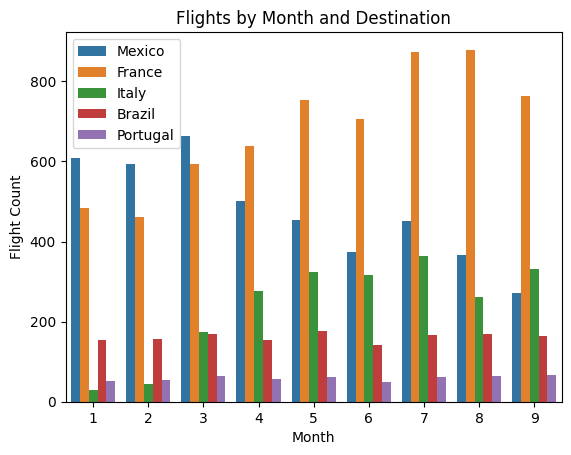

In [21]:
sns.barplot(data=df_mediated, x="MONTH", y="FLIGHTCOUNT", hue="COUNTRY")
plt.legend(title="Destination")
plt.xlabel("Month")
plt.ylabel("Flight Count")
plt.legend()
plt.title("Flights by Month and Destination")

Text(0.5, 1.0, 'Flight Count vs Unemployment Rate')

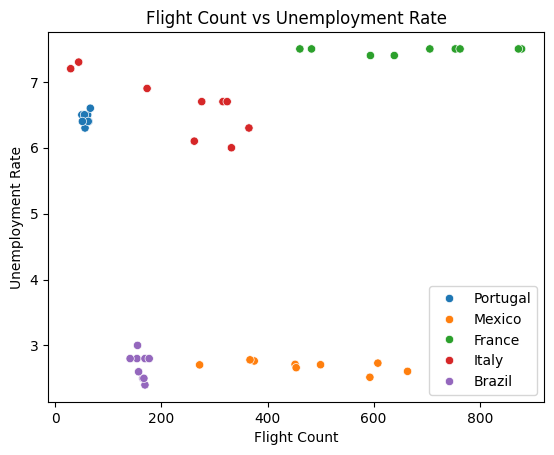

In [22]:
sns.scatterplot(data=df_mediated, x="FLIGHTCOUNT", y="UNEMPLOYMENT", hue="COUNTRY")
plt.legend(title="Destination")
plt.xlabel("Flight Count")
plt.ylabel("Unemployment Rate")
plt.legend()
plt.title("Flight Count vs Unemployment Rate")

## Linear Regression

In [47]:
X = df_mediated[['MONTH', 'COUNTRY', 'PRODUCTION', 'UNEMPLOYMENT', 'CONFIDENCE', 'BARRO']]
y = df_mediated['FLIGHTCOUNT']

In [48]:
X.head()

,MONTH,COUNTRY,PRODUCTION,UNEMPLOYMENT,CONFIDENCE,BARRO
0,8,Portugal,91.469348,6.400000,-14.30,-0.180511
1,1,Mexico,104.303261,2.731031,50.49,0.079364
2,6,Mexico,105.317490,2.763282,52.16,0.171476
3,2,France,98.752115,7.500000,-29.60,-0.446832
4,4,Italy,99.377138,6.700000,-18.70,-0.304729


In [49]:
X = pd.get_dummies(X)
X[['COUNTRY_Brazil', 'COUNTRY_France', 'COUNTRY_Italy', 'COUNTRY_Mexico', 'COUNTRY_Portugal']] = X[['COUNTRY_Brazil', 'COUNTRY_France', 'COUNTRY_Italy', 'COUNTRY_Mexico', 'COUNTRY_Portugal']].astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [50]:
model = LinearRegression()
model.fit(X_scaled, y)
model.coef_

array([  15.11636908, -160.35738888, -261.94234826, -388.41320899,
         33.2901781 , -140.91803468,   97.02384769,  -32.55640068,
        254.37443351, -177.92384585])

In [59]:
equation = f"{round(model.intercept_, 2)}"  # Start with the intercept
for var, coef in zip(X.columns, model.coef_):
    equation += f" + {round(coef, 2)} * {var}"  # Append each term

print(f"FlightCount = {equation}")

FlightCount = 323.09 + 15.12 * MONTH + -160.36 * PRODUCTION + -261.94 * UNEMPLOYMENT + -388.41 * CONFIDENCE + 33.29 * BARRO + -140.92 * COUNTRY_Brazil + 97.02 * COUNTRY_France + -32.56 * COUNTRY_Italy + 254.37 * COUNTRY_Mexico + -177.92 * COUNTRY_Portugal


Text(0, 0.5, 'Variables')

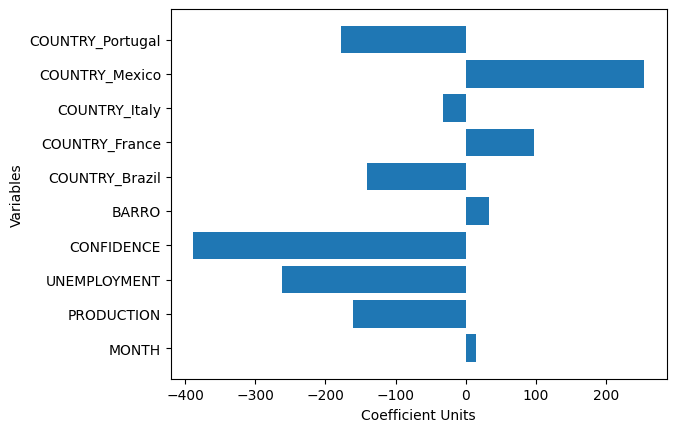

In [64]:
coef_df = pd.DataFrame({"Variable": X.columns, "Coefficients": model.coef_})
plt.barh(coef_df['Variable'], coef_df['Coefficients'])
plt.xlabel('Coefficient Units')
plt.ylabel('Variables')